In [1]:
!ls

PermissionError: [WinError 5] Access is denied

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [5]:
train = datas.MNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
test = datas.MNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())

5,0,4,1,9,2,1,3,1,

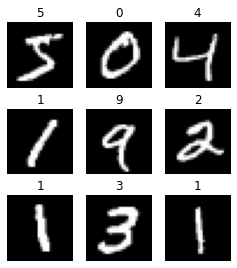

In [51]:
for i in range(9):
    image = train[i][0].numpy().squeeze()
    plt.subplot(3,3,i+1)
    plt.gcf().set_size_inches(4,4.5)
    plt.gca().axis('off')
    plt.imshow(image, cmap = 'gray') 
    plt.title(train[i][1])
    print(train[i][1], end = ',')

In [7]:
total_batch = len(train)
data_per_batch = 500
batches = int(total_batch / data_per_batch)
iterations = 3000
epoch = int(iterations / data_per_batch)
batches

120

In [8]:
train_loader = DataLoader(train, batch_size = batches, shuffle = True)
validation_loader = DataLoader(test, batch_size = 5000, shuffle = False)

In [27]:
class classifying_model(nn.Module):
    def __init__(self, input_shapes, output_shapes):
        super(classifying_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 4, stride = 1, padding = 0)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4, stride = 1, padding = 0)
        
        self.fc = nn.Sequential(
                        nn.Linear(32*4*4, 225),
                        nn.ReLU(inplace = True),
                        nn.BatchNorm1d(225),
                        nn.Linear(225, output_shapes)
                        )
    def forward(self, x):
        out = self.maxpool(self.relu(self.conv1(x)))
        out = self.maxpool(self.relu(self.conv2(out)))
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [28]:
input_size = 28 * 28
learning_rate = 0.1

In [29]:
model = classifying_model(input_shapes = input_size, output_shapes = 10)
# model2 = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [30]:
i, j = next(iter(train_loader))
i.view(-1, 28*28).shape

torch.Size([120, 784])

In [32]:
print('started')
itera = 0
loss_list = []
accuracy_list = []
for i in range(epoch):
    for n, (images, label) in enumerate(train_loader):
#         images = Variable(images.view(-1, 28 * 28))
        model.train()
        optimizer.zero_grad()
        pred = model(images)
        _, predictions = torch.max(pred, 1)
        accuracy = accuracy_score(predictions, label)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        itera += 1
        if n % 300 == 0:
            for j, (images, label) in enumerate(validation_loader):
#                 images = Variable(images.view(-1, 28 * 28))
                model.eval()
                pre = model(images)
                _, predictions = torch.max(pre, 1)
                test_accuracy = accuracy_score(predictions, label)
                test_loss = criterion(pre, label)
        

            print(f'{itera} | training_loss ---> {loss:.4f} | train_acc ---> {accuracy:.4f} | test_acc ---> {test_accuracy:.4f} | validating_loss ---> {test_loss:.4f}')
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
print('finished')            

started
1 | training_loss ---> 1.4619 | train_acc ---> 0.5750 | test_acc ---> 0.3808 | validating_loss ---> 2.2145
301 | training_loss ---> 0.1676 | train_acc ---> 0.9500 | test_acc ---> 0.9796 | validating_loss ---> 0.0746
501 | training_loss ---> 0.0997 | train_acc ---> 0.9667 | test_acc ---> 0.9866 | validating_loss ---> 0.0477
801 | training_loss ---> 0.0258 | train_acc ---> 1.0000 | test_acc ---> 0.9940 | validating_loss ---> 0.0243
1001 | training_loss ---> 0.0242 | train_acc ---> 0.9917 | test_acc ---> 0.9932 | validating_loss ---> 0.0246
1301 | training_loss ---> 0.0210 | train_acc ---> 0.9917 | test_acc ---> 0.9932 | validating_loss ---> 0.0211
1501 | training_loss ---> 0.0117 | train_acc ---> 1.0000 | test_acc ---> 0.9946 | validating_loss ---> 0.0196
1801 | training_loss ---> 0.0352 | train_acc ---> 0.9833 | test_acc ---> 0.9950 | validating_loss ---> 0.0195
2001 | training_loss ---> 0.0147 | train_acc ---> 1.0000 | test_acc ---> 0.9952 | validating_loss ---> 0.0189
2301 | t

KeyboardInterrupt: 

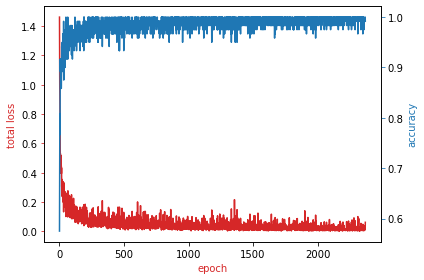

In [34]:



# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## checking out some predictions made

tensor([8, 3, 8, 5, 6, 1, 2, 1, 1, 2, 3, 5, 7, 2, 4, 9, 3, 7, 0, 6, 2, 0, 4, 3,
        2])
tensor([8, 3, 8, 5, 6, 1, 2, 1, 1, 2, 3, 5, 7, 2, 4, 9, 3, 7, 0, 6, 2, 0, 4, 3,
        2])


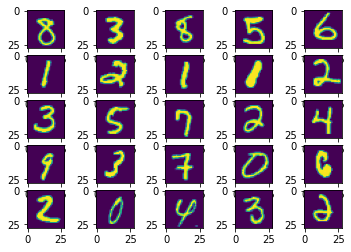

In [38]:
print(predictions[:25])
print(label[:25])
for i in range(25):
    plt.subplot(5,5,i+1 % 5)
    im = images[i].view(28, 28)
    plt.imshow(im)

## checking the wrong predictions made

 wrong predicted === tensor([3, 7])
correct label === tensor([8, 2])


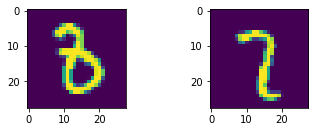

In [40]:
import math
print(f' wrong predicted === {predictions[predictions != label]}')
print(f'correct label === {label[predictions != label]}')
n_wrong = images[predictions != label].shape[0]
root = math.ceil(math.sqrt(n_wrong))
for i in range(n_wrong):
    plt.subplot(root, root,i+1 % 5)
    im = images[predictions != label][i].view(28, 28)
    plt.imshow(im)

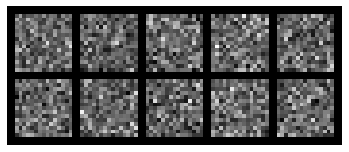

In [44]:
import torchvision
def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')
    
def display_thumb(img):
  display.display(transforms.Resize(128)(img))

assert model.fc[3].weight.shape == (10, 15 * 15)
show(torchvision.utils.make_grid(
    model.fc[3].weight.view(10, 1, 15, 15),
    normalize=True,
    nrow=5,
))